## Exploring the Dataset 

### Imports

In [1]:
import numpy as np
import pandas as pd
import re

In [13]:
train_path = "D:\Data-cfm\X_train.csv"
test_path = "D:\Desktop\Coding-Projects\Prediction-Challenge\Data\y_train.csv"

In [ ]:
df = pd.read_csv(train_path)

In [25]:
df[120:].head(15)

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
120,1,5,16,A,B,-0.79,0.00,0.04,2,75,False,100
121,1,3,17,U,A,0.06,0.00,0.04,2,75,False,-25
122,1,5,18,U,A,0.04,0.00,0.04,2,54,True,-21
123,1,1,19,A,B,-0.03,0.00,0.04,2,54,False,100
124,1,1,20,D,B,-0.04,0.00,0.04,2,54,False,-100
125,1,5,18,D,A,0.04,0.00,0.04,2,54,True,-54
126,1,2,21,A,B,-0.01,0.00,0.06,2,384,False,100
127,1,5,22,D,B,-0.60,0.00,0.06,2,384,False,-100
128,1,4,23,A,B,0.01,0.01,0.06,200,384,False,200
129,1,4,24,A,B,0.01,0.01,0.06,300,384,False,100


In [27]:
y_train = pd.read_csv(test_path)
y_train.head()

,obs_id,eqt_code_cat
0,0,10
1,1,15
2,2,0
3,3,13
4,4,0


Data = 504 days × 24 stocks × 20 observations/day × 100 events/observation  

Here is a description of each column in the dataset. <br>

| Column | Description |
| ------ | ------------ |
| **Obs_id** | which observation are we taking into account <br>-> for that observation we will keep track of the next 100 operations in the book orders |
| **Venue_id** | for a given stock, exchanges can happen across many venues :  this id tracks which venue we consider <br> ==> it could be of importance (some stocks are typically traded across many venues ?) |
| **order_id** | for a given observation sequence, each operation is related to an order. An order can be added, updated, deleted. <br>The order_id allows to track the lifecycle of individual orders within a sequence.   |
| **action** |  A (adding an order to the book) , D (Deleting an order from the book), U = updating an action from the book |
| **side** | B (bids, values to buy the action) , A (Ask, values to sell the action) 
| **Price** | - price : price of the order that was affected. *This best_bid_price , at the time of the first event, is substracted from all price reated columns (price, bid, ask  ) |
| **bid , ask** |- bid , ask == best bid (highest bid) /best ask (lowest ask)   |
| **bid_size, ask_size** |  volume of orders at the best bid, respectively ask, price  , on the *aggregated book* <br> => this too could be a valuable information, perhaps some stocks are encoutering more volume than others.  |
|**flux** | the change in volume at a specific price level in the order book due to a particular event |
|**Trade**|A boolean true or false to indicate whether a deletion or update event was due to a trade or due to a cancellation. <br> Most Deletions and updates actually dont occur from Trades

# Explore trade info intuition 

In [ ]:
# Filter actions that are either 'D' or 'U'
du_actions = df[(df['action'].isin(['D', 'U']))]

# Count actions where 'trade' is True among 'D' or 'U'
du_trades = du_actions[du_actions['trade'] == True]

# Calculate the percentage
percentage = (len(du_trades) / len(du_actions)) * 100

# Display the result
print(f"Percentage of 'D' or 'U' actions coming from trades: {percentage:.2f}%")



Percentage of 'D' or 'U' actions coming from trades: 0.95%


In [28]:
# Merge the main DataFrame (df) with y_train using obs_id
df = df.merge(y_train, on='obs_id', how='left')  # Assuming y_train has columns ['obs_id', 'stock']


In [29]:
# Define a function to calculate the percentage for each observation
def calculate_percentage(sub_df):
    is_du = sub_df['action'].isin(['D', 'U'])
    is_du_trade = is_du & (sub_df['trade'] == True)
    return (is_du_trade.sum() / is_du.sum()) * 100 if is_du.sum() > 0 else 0

# Group by obs_id and calculate percentage
df_obs = df.groupby('obs_id').apply(calculate_percentage).reset_index(name='percentage')


C:\Users\yaeld\AppData\Local\Temp\ipykernel_12172\3720576046.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_obs = df.groupby('obs_id').apply(calculate_percentage).reset_index(name='percentage')


In [34]:
df_obs = df_obs.merge(y_train, on='obs_id', how='left')

                  mean       std  min        max
eqt_code_cat                                    
0             0.849016  2.031025  0.0  24.000000
1             0.884358  2.029311  0.0  20.754717
2             0.670386  1.727109  0.0  20.833333
3             1.016243  2.179874  0.0  30.508475
4             0.817719  1.974106  0.0  28.070175
5             0.847013  1.976205  0.0  25.423729
6             1.123954  2.493979  0.0  30.769231
7             0.561587  1.635547  0.0  22.807018
8             2.040352  3.525672  0.0  32.203390
9             0.904126  2.140357  0.0  28.260870
10            1.043732  2.212074  0.0  27.777778
11            0.964298  2.163864  0.0  20.370370
12            0.885079  2.190235  0.0  34.693878
13            0.645487  1.694719  0.0  18.867925
14            1.166447  2.480337  0.0  26.666667
15            1.086774  2.228065  0.0  29.166667
16            0.898840  2.211347  0.0  23.809524
17            1.027150  2.240280  0.0  28.571429
18            0.5959

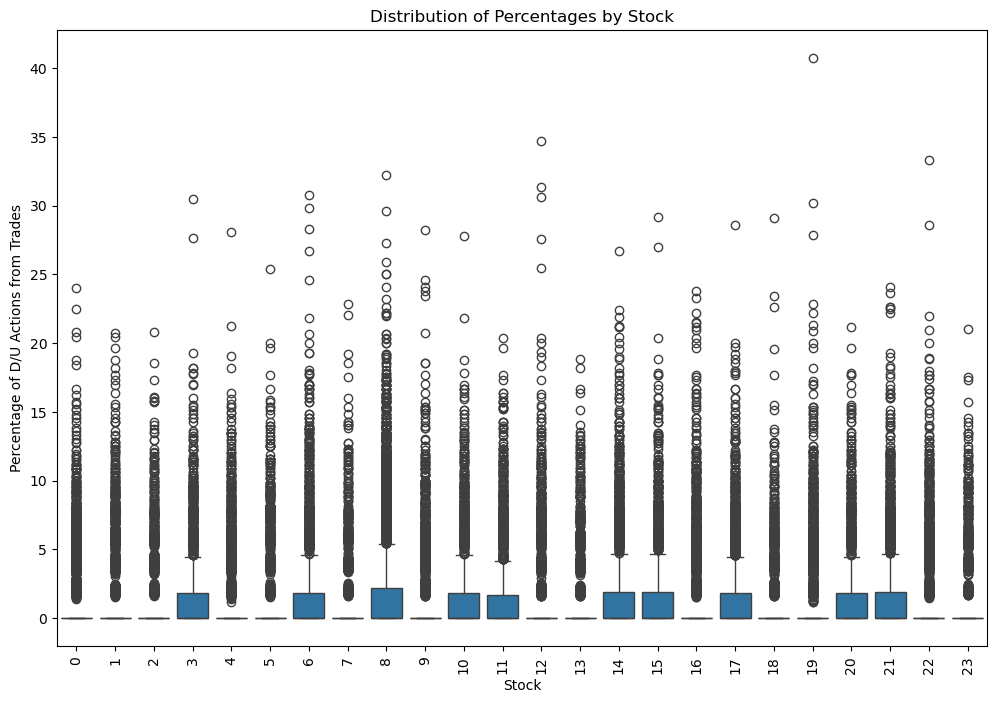

In [ ]:
# Group by stock and calculate statistics
stock_stats = df_obs.groupby('eqt_code_cat')['percentage'].agg(['mean', 'std', 'min', 'max'])

# Visualize distribution for each stock
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='eqt_code_cat', y='percentage', data=df_obs)
plt.title('Distribution of Percentages by Stock')
plt.xlabel('Stock')
plt.ylabel('Percentage of D/U Actions from Trades')
plt.xticks(rotation=90)
plt.show()

C:\Users\yaeld\AppData\Local\Temp\ipykernel_12172\3721508799.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')


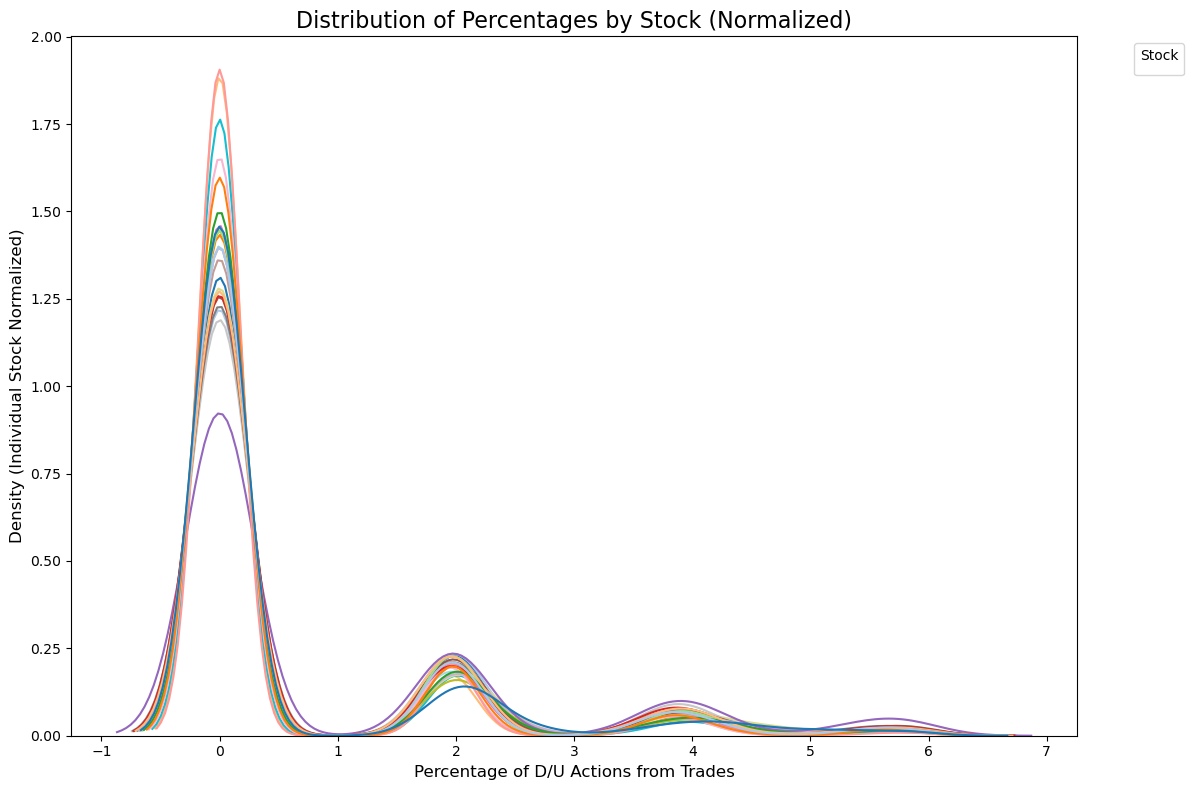

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cap percentages at 15% by filtering the data
df_obs_capped = df_obs[df_obs['percentage'] <= 6]

# Create a normalized KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=df_obs_capped,
    x='percentage',
    hue='eqt_code_cat',
    fill=False,
    common_norm=False,  # Normalize each stock individually
    palette='tab20'
)

plt.title('Distribution of Percentages by Stock (Normalized)', fontsize=16)
plt.xlabel('Percentage of D/U Actions from Trades', fontsize=12)
plt.ylabel('Density (Individual Stock Normalized)', fontsize=12)
plt.legend(title='Stock', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



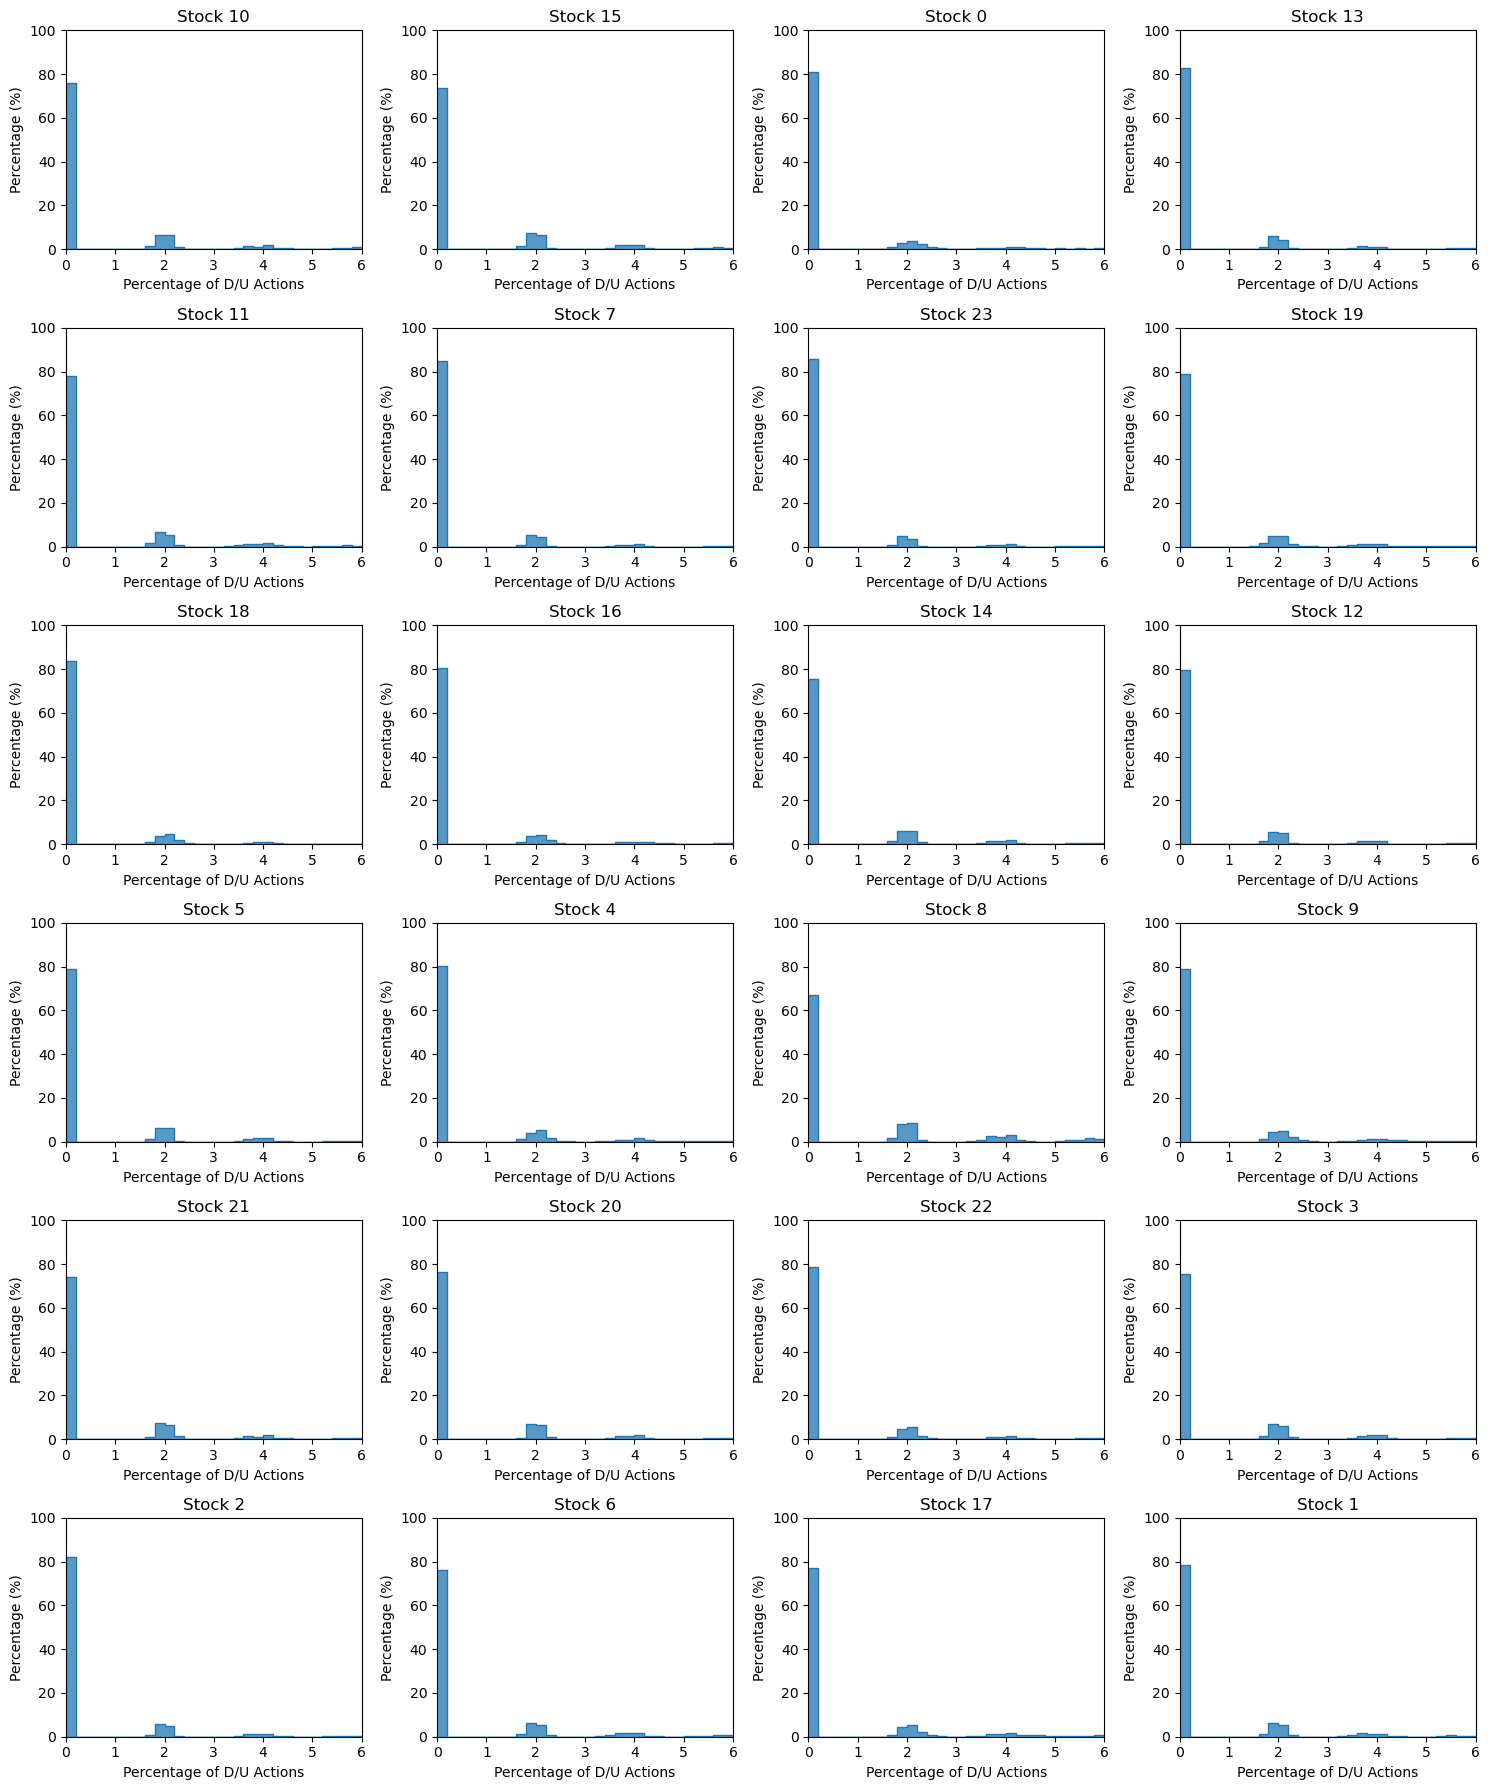

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cap percentages at 6%
df_obs_capped = df_obs[df_obs['percentage'] <= 6]

# Create subplots: One histogram per stock
stocks = df_obs_capped['eqt_code_cat'].unique()  # Get unique stocks
num_stocks = len(stocks)

# Define the number of rows and columns for subplots
ncols = 4  # Number of columns
nrows = (num_stocks + ncols - 1) // ncols  # Calculate rows based on number of stocks

# Create the figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()  # Flatten axes for easier indexing

# Plot each stock
for i, stock in enumerate(stocks):
    # Filter the data for the current stock
    stock_data = df_obs_capped[df_obs_capped['eqt_code_cat'] == stock]
    
    # Plot the histogram for the stock
    sns.histplot(
        stock_data,
        x='percentage',
        bins=30,
        ax=axes[i],
        element='step',
        stat='percent'  # Show percentages instead of counts
    )
    axes[i].set_title(f'Stock {stock}', fontsize=12)
    axes[i].set_xlim(0, 6)  # Cap the percentage at 6
    axes[i].set_ylim(0, 100)  # Cap the y-axis at 100%
    axes[i].set_xlabel('Percentage of D/U Actions', fontsize=10)
    axes[i].set_ylabel('Percentage (%)', fontsize=10)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


There seems to be three modes : 0% of trades , 2% of trades, 4% of trades 

### Example: For a given Observation

| `order_id` | `action` | `price` | `side` | **Description**                                          |
|------------|----------|---------|-------|----------------------------------------------------------|
| 0          | A        | 100.5   | B     | A new order (ID 0) is added at 100.5 on the bid side.    |
| 1          | A        | 101.0   | A     | A new order (ID 1) is added at 101.0 on the ask side.    |
| 0          | U        | 100.5   | B     | The order with ID 0 is updated (e.g., quantity changed). |
| 1          | D        | 101.0   | A     | The order with ID 1 is deleted (removed from the book).  |


In [ ]:
# Load a small part of the DataFrame for testing
subset_df = pd.read_csv(train_path, nrows=1e5)  # Load only the first 100,000 rows
filtered_subset = subset_df[subset_df['trade'] == True]
filtered_subset.head(15)  # Display the first 15 rows


,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
122,1,5,18,U,A,0.04,0.00,0.04,2,54,True,-21
125,1,5,18,D,A,0.04,0.00,0.04,2,54,True,-54
188,1,5,42,U,A,0.06,0.02,0.06,701,310,True,-21
257,2,5,46,D,A,0.01,0.00,0.01,1537,200,True,-100
683,6,5,45,U,A,0.01,0.00,0.01,800,50,True,-50
686,6,5,45,D,A,0.01,0.00,0.01,800,150,True,-50
1631,16,5,27,D,B,0.00,0.00,0.01,295,100,True,-100
1632,16,5,28,D,B,0.00,0.00,0.01,295,100,True,-100
1659,16,5,43,D,A,0.01,-0.01,0.01,1,100,True,-100
2563,25,5,40,D,B,0.00,0.00,0.05,398,100,True,-100


In [19]:
# Load a small part of the DataFrame for testing
subset_df = pd.read_csv(train_path, nrows=1e5)  # Load only the first 100,000 rows
filtered_subset = subset_df[(subset_df['obs_id'] == 1) & (subset_df['order_id']==18)]
filtered_subset.head(15)  # Display the first 15 rows


,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
122,1,5,18,U,A,0.04,0.0,0.04,2,54,True,-21
125,1,5,18,D,A,0.04,0.0,0.04,2,54,True,-54


# Some ideas after the initial exploration

For a given observation, what can help determine the stock ? we could use visualisation (for a given stock : average volatility observed , average number of increase of orders, average number of decrease of oders etc simple metrics as such)  
  
To go more in depth : we must use embeddings of our data, think of interesting traits, use correlations, try and reduce the dimensionality.  
--> ideas seem endless we could train an embedding matrix to predict the venue idk man 